In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import sys
from scipy.optimize import curve_fit, leastsq

%matplotlib inline

### Fetching the data from the files

In [5]:
def create_df(filename):
    df= pd.read_json(filename)
    return df

def filter_data(df):    
    mean = df['price'].mean()
    std = df['price'].std()
    lower_range = mean - 2*std
    upper_range = mean + 2*std
    mask = (df['price'] >= lower_range) & (df['price'] <= upper_range)

    df['price'] = df['price'][mask]
    df['duration'] = df['duration'][mask]

    df['departure'] = pd.to_datetime(df['departure'].str[:10])

    df.index = df['departure']
    return df
    
def sort_by_date(df):
    df2 = pd.DataFrame(index=df.index.unique(), columns=['price'])

    for i in df.index.unique():
        df2.loc[i] = df.loc[i, 'price'].quantile(q=0.25)
    return df2



In [11]:
def hist(df, bin):

    x = df['price']
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.legend(['The price density of flights from BHX to IAS'])
    ax.set_xlabel('price')
    ax.set_ylabel('density')
    ax.set_xticks(np.arange(0, np.max(x)+1, 100))
    ax.hist(x, bins=bin)

In [4]:
df = create_df('file1.json')
df = filter_data(df)
df2 = sort_by_date(df)

### Second attempt at trying to find a line of best fit for my data

In [98]:

y = df2['price']
x = df2.index

x_line= (x - pd.Timestamp("01/01/1970")) // pd.Timedelta('1s')

# Finding the amplitude of the sin waves
amp = abs(np.fft.fft(y))
# Finding the frequency of the sin waves
freq = np.fft.fftfreq(len(x_line), (x_line[1]-x_line[0]))
guess_amp = np.std(y) * 2**0.5
guess_freq = abs(freq[np.argmax(amp[1:])+1])
print(guess_freq)
phase = 0
guess_offset = np.mean(y)
guess = [guess_amp, 2*np.pi*guess_freq, phase,  guess_offset]


def sinfunc(x, a, w, p, c):
    return a * np.sin(x*w+p)  + c

def combine_funcs(x_line, y, a, w, p, c):
#x_line, y, a, w, p, c=x_line, y, amp, freq*np.pi*2, 0, guess_offset



    total = np.zeros(shape=len(x_line))
    est_amps = np.empty(len(a))
    est_freq = np.empty(len(a))
    est_phase = np.empty(len(a))
    est_offset = np.empty(len(a))
    for i in range(len(a)):
        popt, pcov= curve_fit(sinfunc, x_line, y,  p0 = [a[i], w[i], p, c])
        est_amps[i] = popt[0]
        est_freq[i] = popt[1]
        est_phase[i] = popt[2]
        est_offset[i] = popt[3]
        #total += sinfunc(x_line, popt[0], popt[1], popt[2], 0)

    ind = np.argpartition(est_amps, -10)[-10:]
    print(ind)
    print(est_amps)
    for i in range(len(a)):
        print(est_amps[i])
        total += sinfunc(x_line, est_amps[i], est_freq[i], est_phase[i], est_offset[i])


    return total

popt, pcov = curve_fit(sinfunc, x_line, y, p0=[guess_amp, 2*np.pi*guess_freq, phase, guess_offset])
y_line2= sinfunc(x_line, *popt)
print(popt)

fig, ax = plt.subplots(figsize = (12, 6))
ax.scatter(x, y, color = 'red', marker='.')
ax.plot(x, y_line2/300+400)

### Third attempt at trying to find a line of best fit for my data

<class 'pandas.core.series.Series'>
Float64Index([610.8468220229075, 611.0042023915229, 611.1612746735125,
              611.3180381545875, 611.4744921194651, 611.6306358518582,
              611.7864686344731, 611.9419897490171, 612.0971984761852,
              612.2520940956757,
              ...
              640.5886643877019, 640.6190060272021, 640.6487792302639,
               640.677982931711,  640.706616064983, 640.7346775621255,
              640.7621663537873, 640.7890813692259, 640.8154215363073,
               640.841185781494],
             dtype='float64', name='departure', length=306)


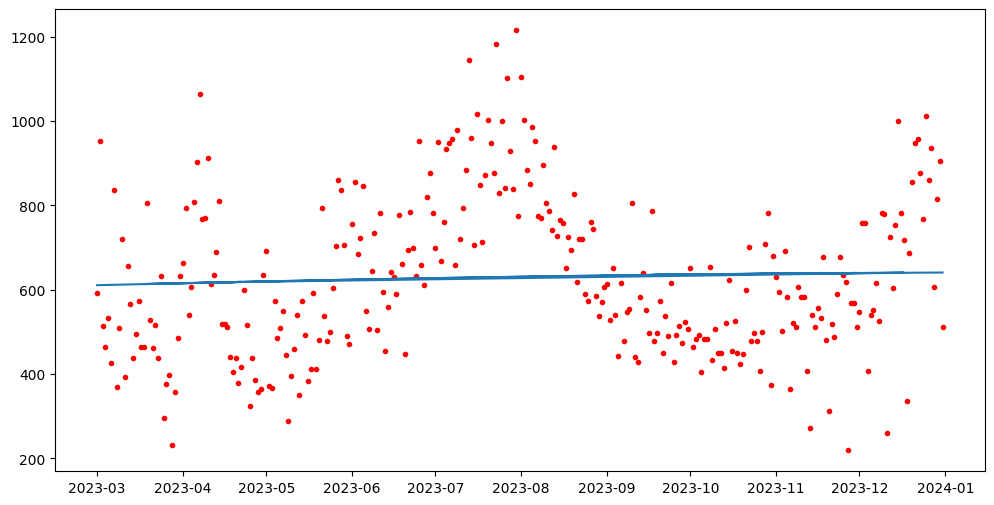

In [122]:
y = df2['price']
x = df2.index
print(type(y))

def using_legendre(x, y):
    x_line= (x - pd.Timestamp("01/01/1970")) // pd.Timedelta('1s')
    y = y.astype(int)

    V = np.polynomial.legendre.legvander(x_line, 20)

    coeffs = np.linalg.lstsq(V, y, rcond=None)[0]
    g = np.polynomial.legendre.legval(x_line, coeffs)
    print(g)
    return g
y_line3 = using_legendre(x, y)
fig, ax = plt.subplots(figsize = (12, 6))
ax.scatter(x, y, color = 'red', marker='.')
ax.plot(x, y_line3)

### Fourth attempt at trying to find a line of best fit, using lmfit. This is very similar to just curve_fit, but a lot harder to use

In [144]:
from lmfit import Model

x_line= (x - pd.Timestamp("01/01/1970")) // pd.Timedelta('1s')
amp = abs(np.fft.fft(y))
freq = np.fft.fftfreq(len(x_line), (x_line[1]-x_line[0]))
guess_freq = abs(freq[np.argmax(amp[1:])+1])
guess_amp = np.std(y) * 2**0.5
guess_offset = np.mean(y)

def function_model(x, a1, a2, a3, w1, w2, w3, p, c):
    return a1 * np.sin(x*w1+p) + a2* np.sin(x*w2+p) + a3 * np.sin(x*w3+p) + c

guess= [guess_amp, guess_amp, guess_amp, guess_freq*np.pi*2, guess_freq*np.pi*2, guess_freq*np.pi*2, 0, guess_offset]
gmodel = Model(function_model)
print(gmodel.param_names)
y_line = gmodel.fit(y,a1=guess[0], a2=guess[1], a3=guess[2], w1=guess[3], w2=guess[4], w3=guess[5], p=guess[6], c=guess[7], x=x_line)
fig, ax = plt.subplots(figsize = (12, 6))
ax.scatter(x, y, color = 'red', marker='.')
print(y_line)
ax.plot(x, y_line.best_fit)


['a1', 'a2', 'a3', 'w1', 'w2', 'w3', 'p', 'c']


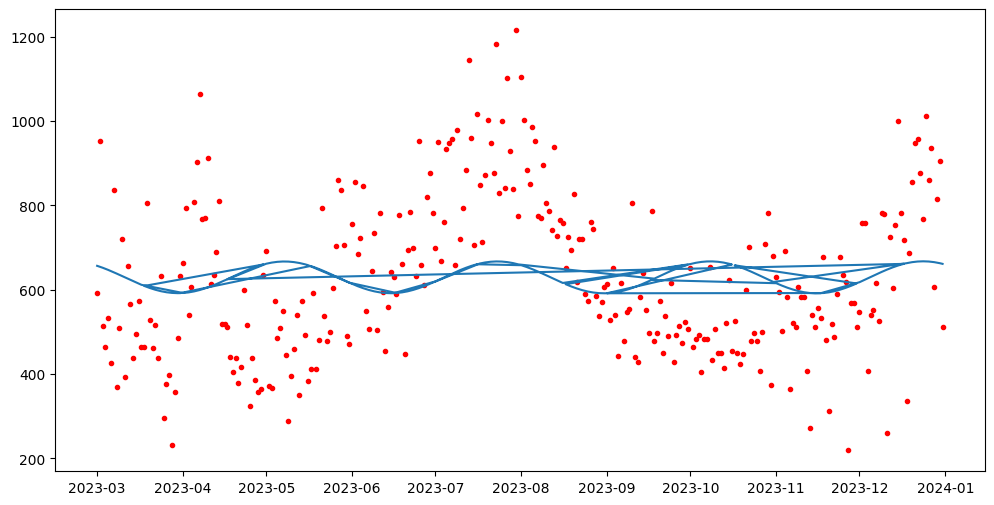